In [1]:
import numpy as np
from benchmark import DataFrame
import matplotlib.pyplot as plt
datas = DataFrame("./res.json")
all_task_names = datas.find_all_task()
all_params = datas.find_all_params()
print("All tasks: ", all_task_names)
print("All parameters: ", all_params)

All tasks:  ['random_circuit_evolution', 'random_ham_expectation', '4_regular_maxcut']
All parameters:  ['framework', 'platform', 'n_qubit']


In [2]:
all_platforms = datas.find_all_keys('platform')
all_frameworks = datas.find_all_keys('framework')
print("All platform: ", all_platforms)
print("All framework: ", all_frameworks)

All platform:  ['cpu', 'gpu']
All framework:  ['intel', 'mindquantum', 'paddle_quantum', 'quest', 'qulacs', 'tensorflow_quantum', 'qiskit', 'qpanda', 'mindquantum_avx']


In [3]:
fw_color_map = {
    'intel': '#293462',
    'mindquantum': 'k',
    'mindquantum_avx': 'r',
    'paddle_quantum': '#a64942',
    'quest': '#e59572',
    'qulacs': '#515bd4',
    'tensorcircuit': '#8134af',
    'tensorflow_quantum': '#dd2a7b',
    'qiskit': '#feda77',
    'qpanda': '#9dd3a8',
}
task_color_map = {
    'random_circuit_evolution': '#de4307',
    'random_ham_expectation': '#f6d04d',
    '4_regular_maxcut': '#8bc24c',
}

# framework_filter = ['tensorcircuit', 'qpanda', 'paddle_quantum']
framework_filter = []

In [4]:
def plot_benchmark(task_name, platform):
    framework_tasks = datas.filter_task(task_name).filter_task_params('platform', platform).split_by_params('framework')
    plt.subplots(dpi=180, figsize=(8, 4))
    x_max, x_min = -np.inf, np.inf
    for f in framework_tasks:
        x, y = f.extra_x_time('n_qubit', np.mean)
        framework_name = f.find_all_keys('framework')[0]
        if framework_name in framework_filter:
            continue
        lw=1
        if framework_name == 'mindquantum':
            lw=2
        plt.plot(x,
                 y,
                 '-',
                 label=framework_name,
                 zorder=-1,
                 c=fw_color_map[framework_name],lw=lw)
        plt.scatter(x,
                    y,
                    s=15,
                    facecolors='w',
                    edgecolors=fw_color_map[framework_name],
                    zorder=2)
        x_max = max(x_max, max(x))
        x_min = min(x_min, min(x))
    plt.xticks(range(x_min, x_max + 1))
    plt.legend(prop={"size": 8}, ncol=2)
    plt.yscale('log')
    plt.title(f"{task_name}({platform})")

In [16]:
qlist, t_ori = datas.filter_task('random_circuit_evolution').filter_task_params('platform', 'cpu').filter_task_params('framework', 'mindquantum').extra_x_time('n_qubit', np.mean)
qlist, t_avx = datas.filter_task(
    'random_circuit_evolution').filter_task_params(
        'platform', 'cpu').filter_task_params('framework',
                                              'mindquantum_avx').extra_x_time(
                                                  'n_qubit', np.mean)
np.array(t_ori)/np.array(t_avx)


array([1.21763016, 1.28553504, 1.35761037, 1.38635262, 1.51412667,
       1.49224978, 1.7009449 , 1.61708711, 1.84260944, 0.86854442,
       0.95718013, 0.91495889, 1.00068139, 1.09494682, 1.13726893,
       1.1275899 , 0.87302433, 0.84478153, 0.88873105, 0.92630954])

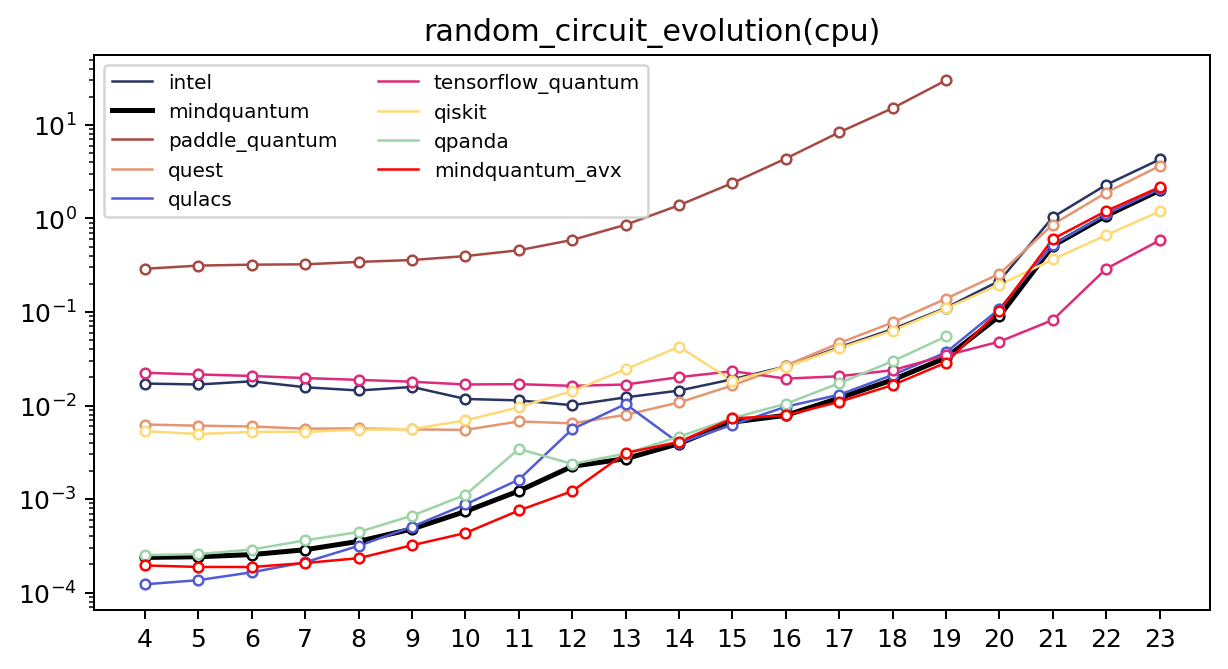

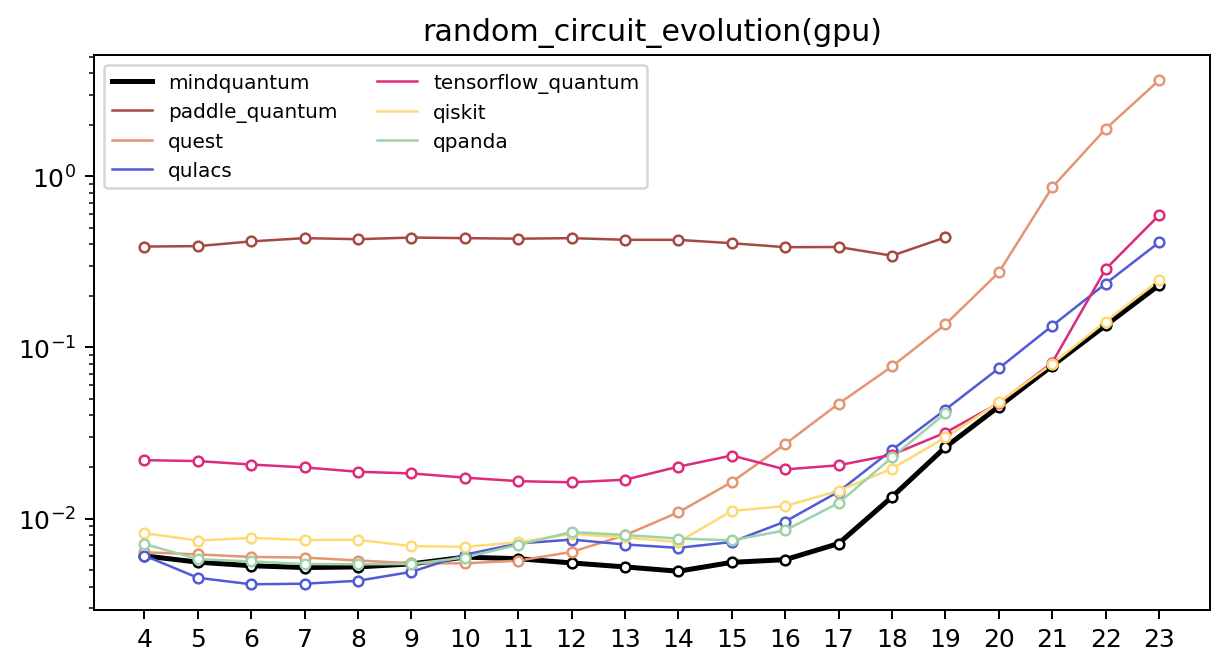

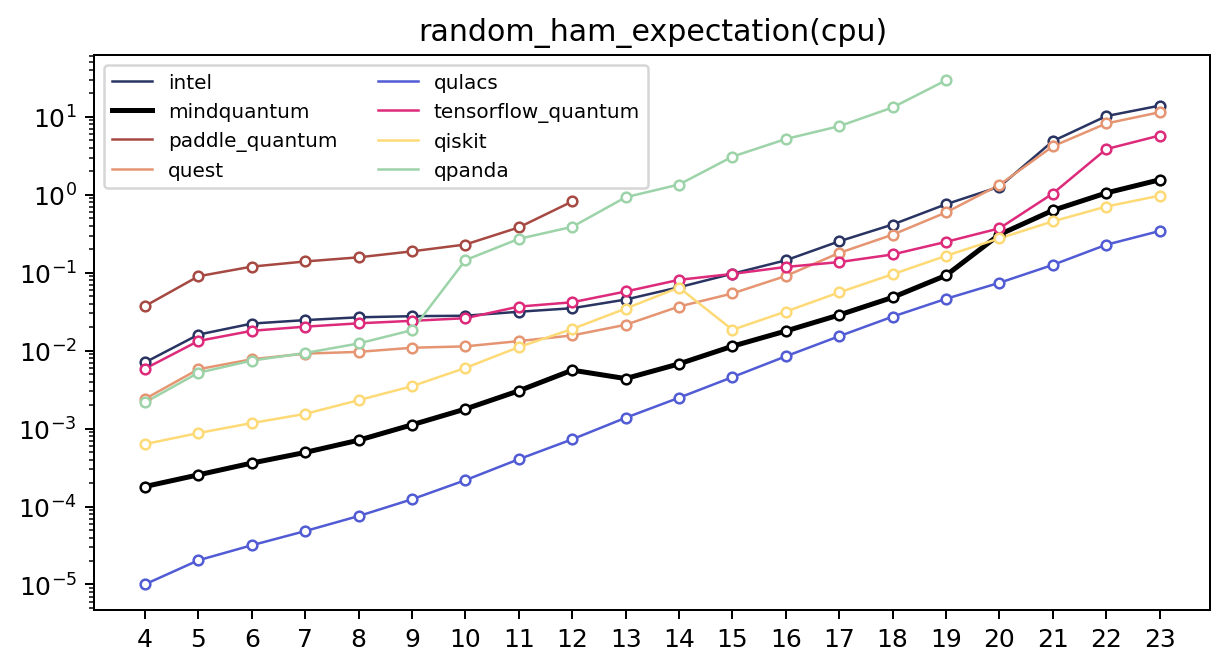

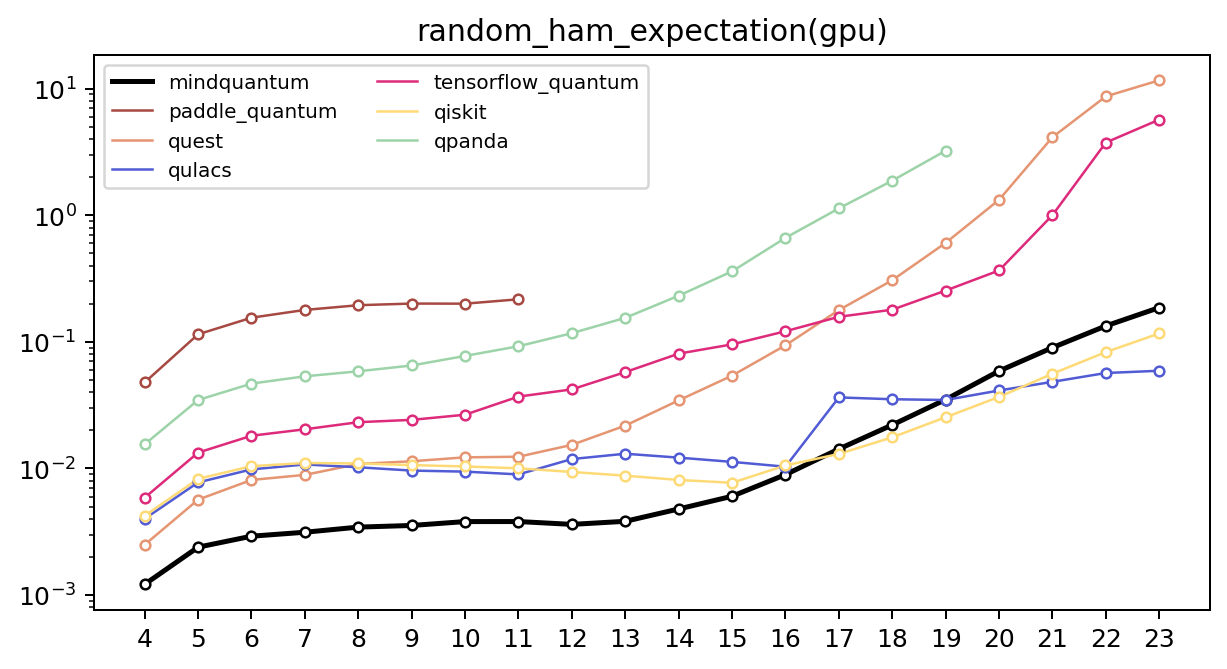

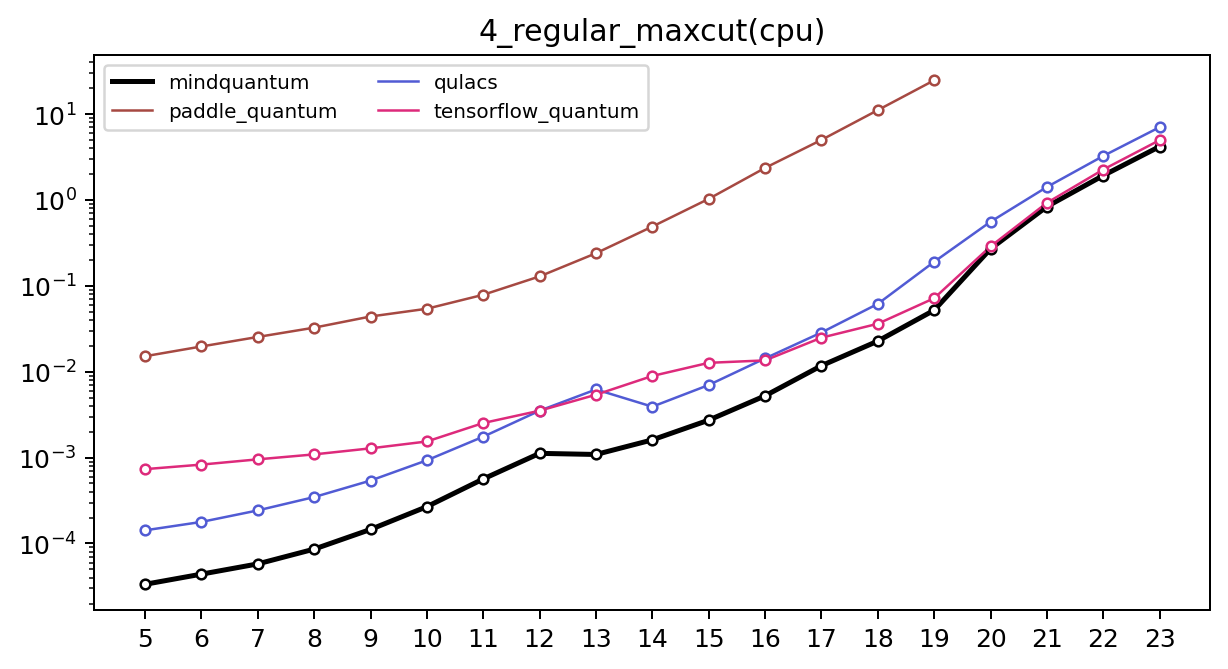

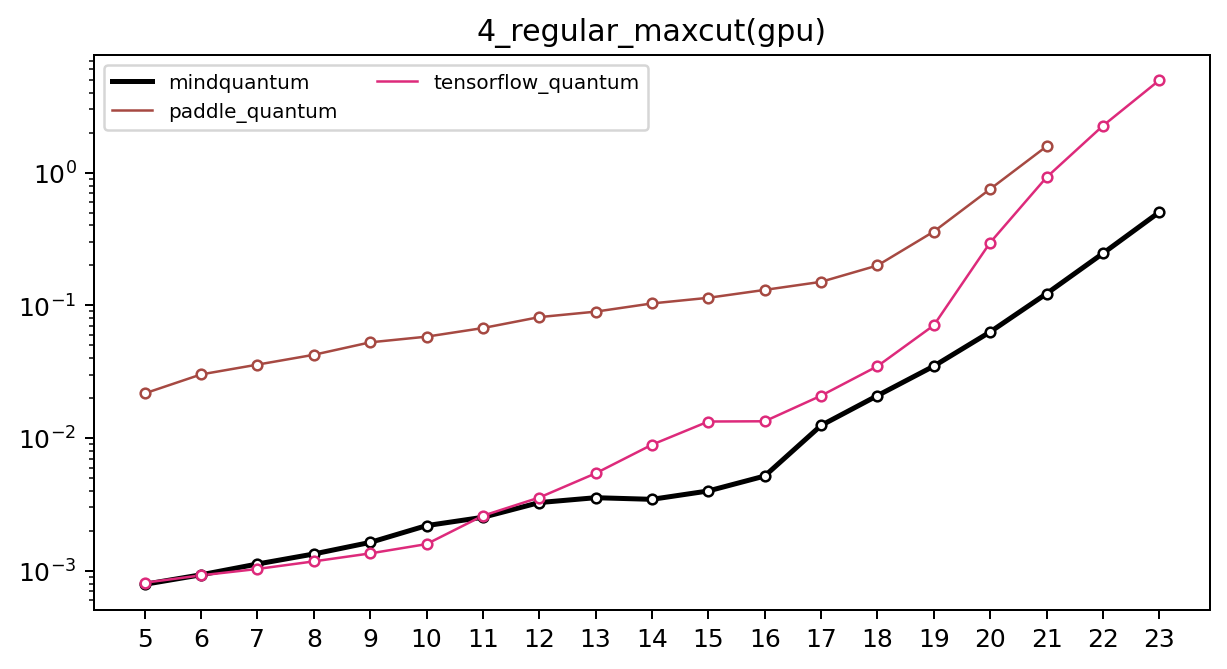

In [5]:
for task_name in all_task_names:
    for platform in all_platforms:
        plot_benchmark(task_name, platform)

In [6]:
print("All tasks: ", all_task_names)
print("All parameters: ", all_params)
print("All platform: ", all_platforms)
print("All framework: ", all_frameworks)

All tasks:  ['random_circuit_evolution', 'random_ham_expectation', '4_regular_maxcut']
All parameters:  ['framework', 'platform', 'n_qubit']
All platform:  ['cpu', 'gpu']
All framework:  ['intel', 'mindquantum', 'paddle_quantum', 'quest', 'qulacs', 'tensorflow_quantum', 'qiskit', 'qpanda', 'mindquantum_avx']


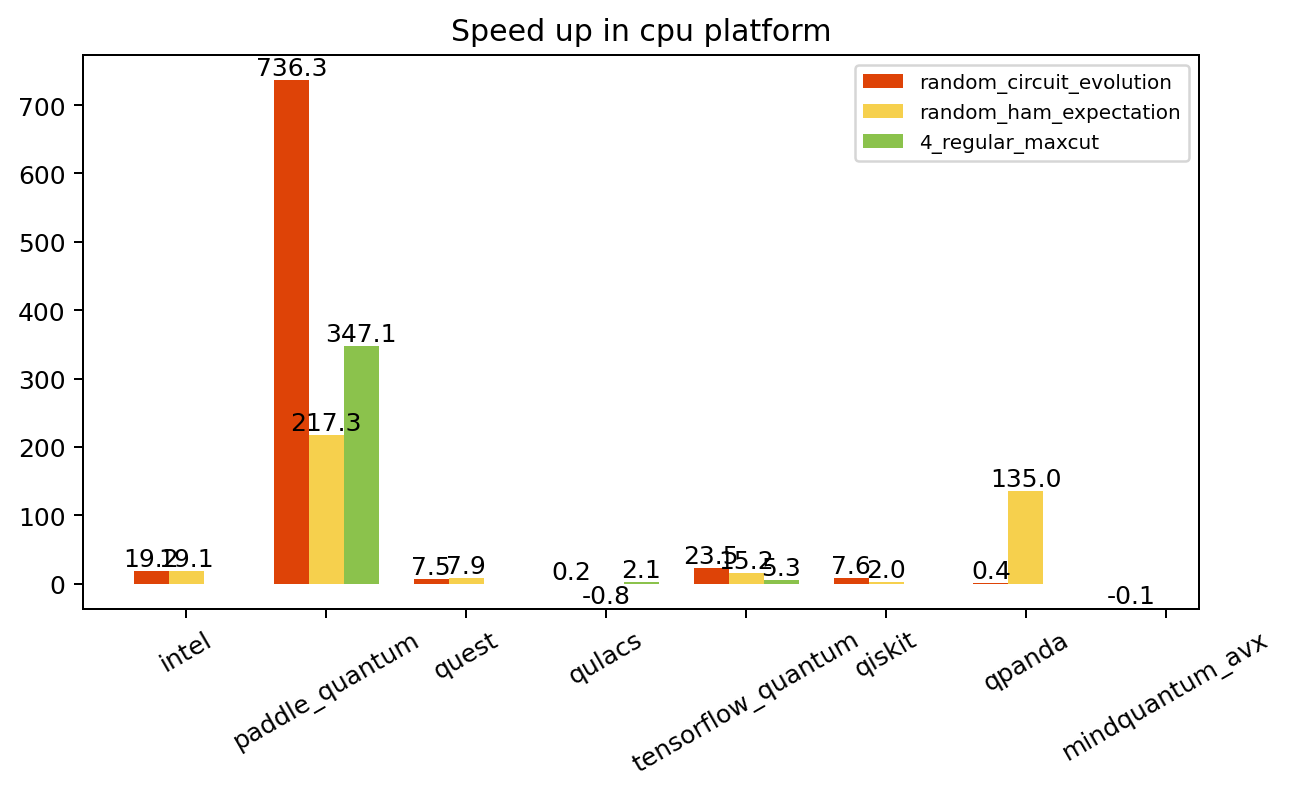

In [7]:
def plot_speedup(platform):
    x_frameworks = datas.filter_task_params('platform', platform).find_all_keys('framework')
    x_frameworks.remove('mindquantum')
    for x in framework_filter:
        x_frameworks.remove(x)
    x_task_names = datas.filter_task_params('platform', platform).find_all_task()
    x = np.arange(len(x_frameworks))
    bar_width = 0.25
    relative_x = np.arange(len(x_task_names))*bar_width-(len(x_task_names)-1)/2*bar_width
    plt.subplots(dpi=180, figsize=(8, 4))

    for task_id, task_name in enumerate(x_task_names):
        rest_tasks = datas.filter_task(task_name).filter_task_params('platform',platform)
        mq_tasks = rest_tasks.filter_task_params('framework','mindquantum')
        mq_n_qubit, mq_time = mq_tasks.extra_x_time('n_qubit', np.mean)
        res_fws = []
        speedups = []
        for framework in rest_tasks.find_all_keys('framework'):
            if framework in framework_filter:
                continue
            if framework != 'mindquantum':
                other_task = rest_tasks.filter_task_params('framework',framework)
                other_n_qubit, other_time = other_task.extra_x_time(
                    'n_qubit', np.mean)
                speedup = []
                for qid in sorted(list(set(other_n_qubit).intersection(set(mq_n_qubit)))):
                    speedup.append(other_time[other_n_qubit.index(qid)] /
                                mq_time[mq_n_qubit.index(qid)] - 1)
                speedup = np.mean(speedup)
                res_fws.append(framework)
                speedups.append(speedup)
        res_x = [x_frameworks.index(framework) + relative_x[task_id] for framework in res_fws]
        plt.bar_label(plt.bar(res_x,
                              speedups,
                              bar_width,
                              label=task_name,
                              facecolor=task_color_map[task_name]),
                      fmt='%.1f')
    plt.xticks(x, x_frameworks, rotation=30)
    plt.legend(loc=1, prop={"size": 8})
    plt.title(f"Speed up in {platform} platform")
plot_speedup('cpu')

In [11]:
plot_speedup('gpu')

ValueError: list.remove(x): x not in list